In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, TargetEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.sparse import spmatrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
import re
sys.path.append(os.path.abspath("../"))
from src.data.load_data import load_dataset
sys.path.append(os.path.abspath("../src")) 
from src.features.preprocess import deterministic_fe
from src.utils.helpers import other_titles,get_personal_title
from src.features.transformers import PersonalTitleTransformer
from src.features.pipe_config import preprocessing_pipeline
from src.utils.helpers import grid_search_res
from joblib import dump
%load_ext autoreload
%autoreload 2

In [3]:
train = load_dataset('../data/raw/train.csv')
test = load_dataset('../data/raw/test.csv')
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_test = test.drop('Survived', axis=1)
y_test = test['Survived']

## Base Tree

In [5]:
tree_mod = Pipeline([
    ('preprocess', preprocessing_pipeline()),
    ('model', DecisionTreeClassifier(random_state = 42))
])

In [6]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = cross_validate(estimator=tree_mod,
                    scoring = scoring,
                    cv = skf,
                    X = X_train, y=y_train,
                    return_train_score=True)
tree_mod.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('Deterministic_fe',
                                  FunctionTransformer(func=<function deterministic_fe at 0x1681f9940>)),
                                 ('personal_title', PersonalTitleTransformer()),
                                 ('encode',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['Embarked',
                                                                    'Personal_titl...
                                                                   ['Ticket_repeated',
                                                                    'Family_size',
                                                                    'Fare',
                                                                    'Parch',
                                                                    'SibSp',
                                                                    'Pclass',
                                                                    'Age'])],
                                                    verbose_feature_names_out=False)),
                                 ('scaling',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('normalization',
                                                                   PowerTransformer(),
                                                                   ['Fare',
                                                                    'Pclass',
                                                                    'SibSp',
                                                                    'Parch',
                                                                    'Age',
                                                                    'Sex',
                                                                    'Family_size'])],
                                                    verbose_feature_names_out=False))])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [8]:
pd.DataFrame(cv)#.to_excel('../reports/model_outputs/train/tree_clf/base_tree_cv.xlsx')

fit_time  score_time  test_accuracy  train_accuracy  \
0  0.028830    0.008629       0.783217        0.959507   
1  0.021660    0.007805       0.795775        0.977153   
2  0.021103    0.007346       0.802817        0.963093   
3  0.023501    0.007970       0.767606        0.973638   
4  0.024731    0.009169       0.795775        0.985940   

   test_precision_weighted  train_precision_weighted  test_recall_weighted  \
0                 0.794121                  0.959836              0.783217   
1                 0.793578                  0.977269              0.795775   
2                 0.800775                  0.963995              0.802817   
3                 0.766825                  0.974099              0.767606   
4                 0.798474                  0.985941              0.795775   

   train_recall_weighted  test_f1_weighted  train_f1_weighted  
0               0.959507          0.785573           0.959594  
1               0.977153          0.792603           0.977182  
2               0.963093          0.800268           0.962818  
3               0.973638          0.767176           0.973715  
4               0.985940          0.796764           0.985928

In [7]:
tree_model = tree_mod.named_steps['model']
plt.figure(figsize=(20,16), dpi=800)
plot_tree(tree_model,
          class_names=['NotSurvived', 'Survived'],
          filled=True,
          rounded=True);
# plt.savefig('../reports/figures/10_overfitted_tree_clf.jpg')

### We can see that the tree is overfitting largely based on a plot and a metrics (train accuracy 99%)
- in order to manage the overfitting I will create a Grid search instance to find the optimal parameters

In [8]:
X_trans = tree_mod.named_steps['preprocess'].fit_transform(X_train,y_train)
path = tree_model.cost_complexity_pruning_path(X_trans, y_train)
ccp_alphas =np.logspace(-4, np.log10(max(path.ccp_alphas)), 40) #Mogę przeszukać więcej bo param grid jest ubogi
# 10^-4 = 0.0001 -> typowa granica lekkiego przycinania



In [40]:
X_trans.columns

Index(['Fare', 'Pclass', 'SibSp', 'Parch', 'Age', 'Sex', 'Family_size',
       'Embarked_Q', 'Embarked_S', 'Personal_title_Mr', 'Personal_title_Mrs',
       'Personal_title_Other', 'Ticket_repeated', 'Unnamed: 0'],
      dtype='object')

In [9]:
param_grid = {'model__ccp_alpha' : ccp_alphas}

In [10]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted',
}
gs = GridSearchCV(tree_mod, scoring = scoring, refit = 'f1', param_grid = param_grid, cv = 5, n_jobs=-1, return_train_score=True)
gs.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/titanic_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/titanic_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/titanic_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('Deterministic_fe',
                                                         FunctionTransformer(func=<function deterministic_fe at 0x1681f9940>)),
                                                        ('personal_title',
                                                         PersonalTitleTransformer()),
                                                        ('encode',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False...
       8.63357383e-03, 1.03959747e-02, 1.25181406e-02, 1.50735114e-02,
       1.81505187e-02, 2.18556461e-02, 2.63171138e-02, 3.16893162e-02,
       3.81581645e-02, 4.59475210e-02, 5.53269454e-02, 6.66210237e-02,
       8.02206009e-02, 9.65963061e-02, 1.16314840e-01, 1.40058586e-01])},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1': 'f1_weighted',
                      'precision': 'precision_weighted',
                      'recall': 'recall_weighted'})

In [11]:
cv_res = pd.DataFrame(gs.cv_results_)
cv_res[cv_res['mean_test_f1'] == max(cv_res['mean_test_f1'])].T.to_excel('../reports/model_outputs/train/tree_clf/best_grid_model.xlsx')
#Train f1 0.83
#Test f1 0.824

In [12]:
gs.best_params_['model__ccp_alpha']

np.float64(0.010395974743138076)

In [13]:
# tree_model = gs.best_estimator.named_steps['model']
plt.figure(figsize=(20,16), dpi=800)
plot_tree(gs.best_estimator_.named_steps['model'],
          class_names=['NotSurvived', 'Survived'],
          filled=True,
          rounded=True);

In [14]:
best_model = gs.best_estimator_
tree = best_model.named_steps['model']
feat_imps = pd.Series(data=tree.feature_importances_, index = X_trans.columns).sort_values(ascending=False)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Personal_title_Mr'),
  Text(1, 0, 'Family_size'),
  Text(2, 0, 'Pclass'),
  Text(3, 0, 'Fare'),
  Text(4, 0, 'SibSp'),
  Text(5, 0, 'Parch'),
  Text(6, 0, 'Age'),
  Text(7, 0, 'Sex'),
  Text(8, 0, 'Embarked_Q'),
  Text(9, 0, 'Embarked_S'),
  Text(10, 0, 'Personal_title_Mrs'),
  Text(11, 0, 'Personal_title_Other'),
  Text(12, 0, 'Ticket_repeated'),
  Text(13, 0, 'Unnamed: 0')])

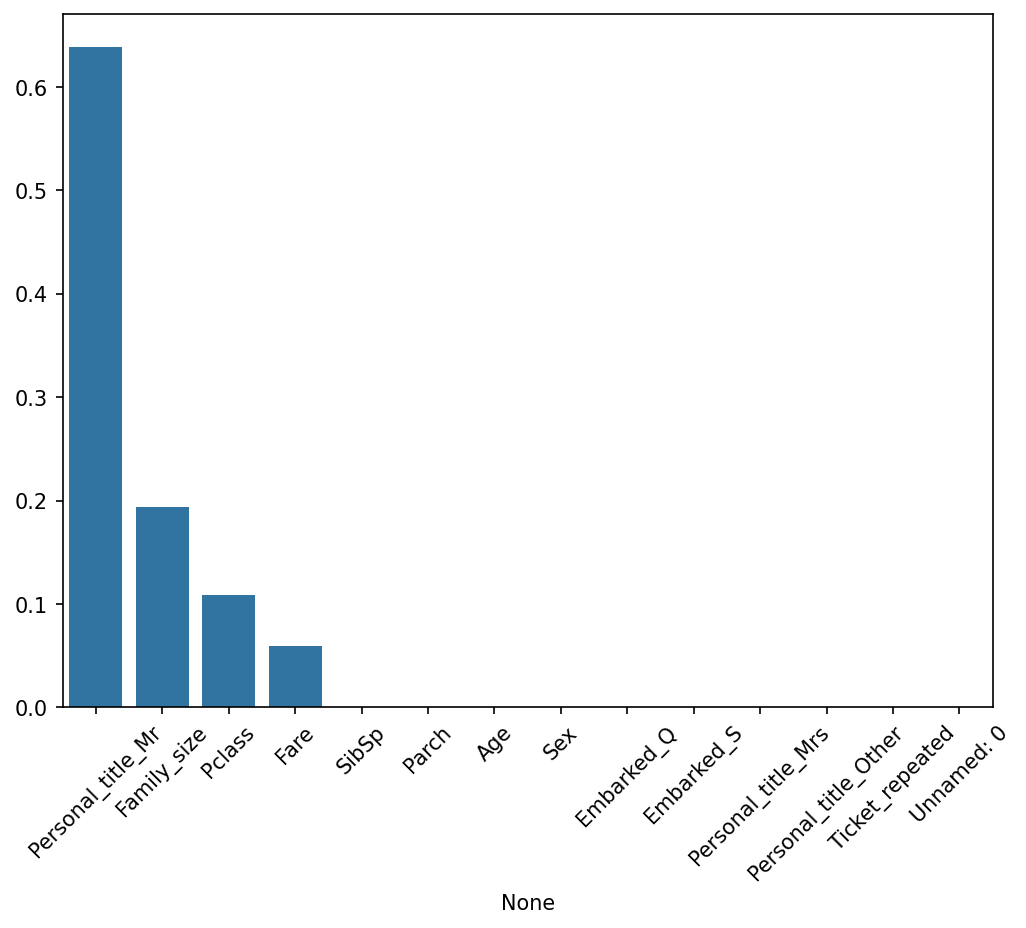

In [15]:
plt.figure(figsize=(8,6), dpi=150)
sns.barplot(x=feat_imps.index, y = feat_imps.values)
plt.xticks(rotation = 45)

The model only uses 4 features in splitting the data basically. I have to check the distribution of the f1 metric against different alpha parameters. I think that the model might be to strict. 

### PERSONAL_TITLE_MR
he feature importances are understandable. While the titanic crashed the first to save were women and children. Due to lack of safety mesaurments (boats) men were left behind. Also it looks like the family size is important in terms of surviving. I see that

### FAMILY SIZE 
The family size variable is interesting becauese if you were alone you had much larger chances to die than if you were with someone (1 or 2 person in family).On the other hand people in families larger than 3 were more likely to not survive. It is also understandable 
Larger families couldn't really focus on their own survival and were slowing each other down. 

### Pclass
The interpretation of that is also pretty obvious. People that had first and second class ticket were the minority at the ship. They also had the highest priority when it comes to place at the boats. This feature is highly correlated with fare

In [ ]:
preprocessing_pipeline().fit_transform(X_train, y_train)

In [ ]:
#Unscaling for model interpretation
prep = tree_mod.named_steps['preprocess']
X_train_transformed = prep.transform(X_train)
scaler = best_model.named_steps['preprocess'].named_steps['scaling'].named_transformers_['normalization']
num_cols = ['Fare', 'Pclass', 'SibSp', 'Parch', 'Age','Sex', 'Family_size']
X_train_trans_num = X_train_transformed[num_cols]
unscaled_X_train = scaler.inverse_transform(X_train_trans_num)
unscaled_X_train = round(pd.DataFrame(unscaled_X_train, columns = X_train_trans_num.columns),2)
X_trans = pd.concat([X_train_transformed.drop(num_cols, axis=1), unscaled_X_train], axis=1)

In [36]:
X_trans['Fam_size_cap'] = X_trans['Family_size'].apply(lambda x: '>=3' if x >= 3 else x)

<Axes: xlabel='Fam_size_cap', ylabel='count'>

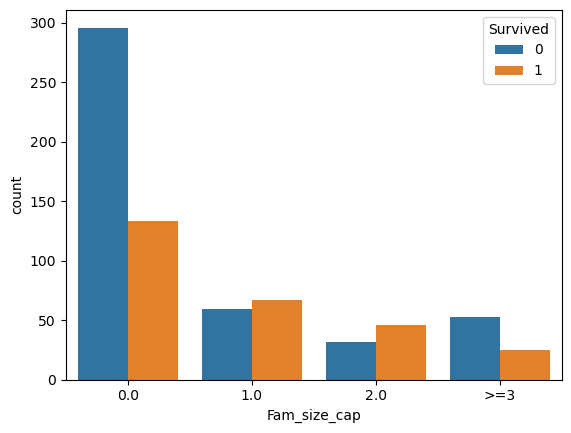

In [ ]:
sns.countplot(x=X_trans['Fam_size_cap'], hue = y_train, order = [0.0,1.0,2.0,'>=3'])


<Axes: xlabel='Pclass', ylabel='count'>

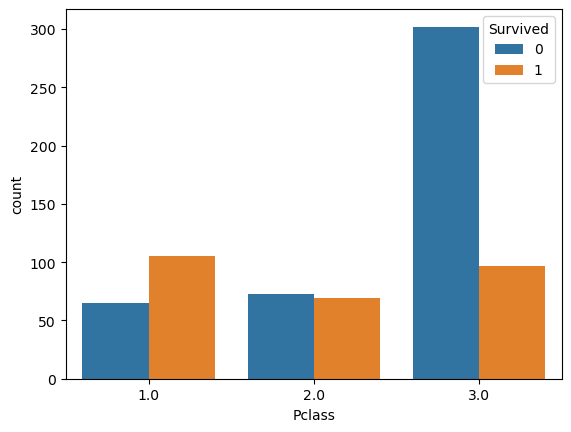

In [42]:
sns.countplot(x=X_trans['Pclass'], hue = y_train)


Text(0.5, 1.0, 'mean F1 metric vs ccp alphas searched')

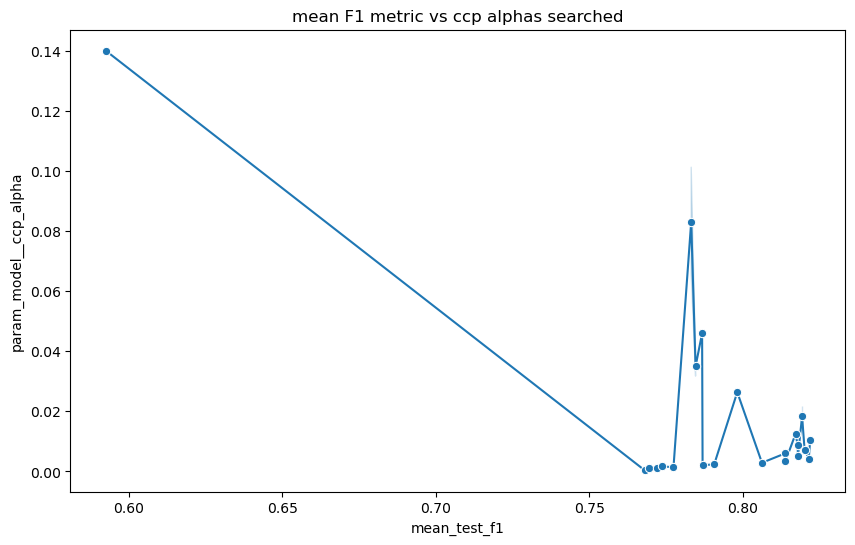

In [63]:
#F1 vs Alpha plot

cv_res['param_model__ccp_alpha']

plt.figure(figsize=(10,6))
sns.lineplot(data = cv_res, y = 'param_model__ccp_alpha',x = 'mean_test_f1',marker='o')
# plt.ylim(0,0.1)
plt.title('mean F1 metric vs ccp alphas searched')
# plt.savefig('../reports/figures/11_F1_vs_alphas')

Text(0.5, 1.0, 'mean F1 metric vs ccp alphas searched')

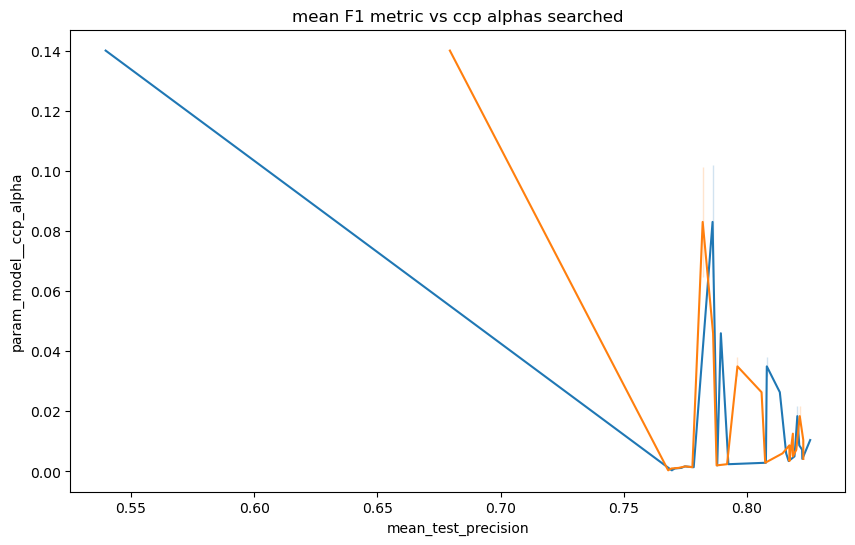

In [53]:
plt.figure(figsize=(10,6))
sns.lineplot(data = cv_res, y = 'param_model__ccp_alpha',x = 'mean_test_precision')
sns.lineplot(data = cv_res, y = 'param_model__ccp_alpha',x = 'mean_test_recall')
# sns.lineplot(data = cv_res, y = 'param_model__ccp_alpha',x = 'mean_test_accuracy')
# plt.ylim(0,0.04)
# plt.xlim(0.8, 0.835)
plt.title('mean F1 metric vs ccp alphas searched')

In [30]:
cv_res[['mean_test_precision', 'mean_test_recall']]

mean_test_precision  mean_test_recall
0              0.769407          0.767980
1              0.769407          0.767980
2              0.769407          0.767980
3              0.769407          0.767980
4              0.769407          0.767980
5              0.769407          0.767980
6              0.769407          0.767980
7              0.769407          0.767980
8              0.769407          0.767980
9              0.769407          0.767980
10             0.769407          0.767980
11             0.769407          0.767980
12             0.770752          0.769388
13             0.773340          0.772205
14             0.778362          0.777819
15             0.774739          0.774993
16             0.787901          0.787649
17             0.792436          0.791894
18             0.807653          0.807367
19             0.816874          0.817207
20             0.822434          0.822841
21             0.819256          0.818615
22             0.815879          0.814400
23             0.822344          0.819984
24             0.821189          0.817187
25             0.825624          0.822821
26             0.819916          0.818595
27             0.820401          0.821383
28             0.820401          0.821383
29             0.820401          0.821383
30             0.813301          0.805890
31             0.808021          0.796100
32             0.808021          0.796100
33             0.789373          0.786221
34             0.786010          0.781995
35             0.786010          0.781995
36             0.786010          0.781995
37             0.786010          0.781995
38             0.786010          0.781995
39             0.539736          0.679415

### No need for further parameter tunning. Model already satisfying